# Perihepatic Abscess Creep

Fit creep compliance of perihepatic abscess data.

**Data:** examples/data/creep/biological/creep_perihepatic_data.csv


In [1]:
# Google Colab compatibility - uncomment if running in Colab
# !pip install -q rheojax
# from google.colab import drive
# drive.mount('/content/drive')


## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
%matplotlib inline

import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rheojax.models import FractionalMaxwellModel
from rheojax.models import GeneralizedMaxwell

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.pipeline.base import Pipeline

jax, jnp = safe_import_jax()
verify_float64()
np.set_printoptions(precision=4, suppress=True)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
warnings.filterwarnings('ignore', category=RuntimeWarning)

def r2_complex(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
    ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot)

def mpe(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return float(np.mean(np.abs(y_true - y_pred) / np.maximum(np.abs(y_true), 1e-12)) * 100)

def load_tab_file(path):
    df = pd.read_csv(path, sep='	')
    df.columns = df.columns.str.strip()
    df = df.dropna()
    df.iloc[:,0] = pd.to_numeric(df.iloc[:,0], errors='coerce')
    df.iloc[:,1] = pd.to_numeric(df.iloc[:,1], errors='coerce')
    df = df.dropna()
    return df
import arviz as az


## Load creep compliance data

In [3]:
DATA_DIR = Path.cwd().parent / 'data' / 'creep' / 'biological'
df = load_tab_file(DATA_DIR / 'creep_perihepatic_data.csv')
t = df.iloc[:,0].to_numpy()
J = df.iloc[:,1].to_numpy()
print(df.head())


       Time  Creep Compliance
0  0.010000          0.024139
1  0.010243          0.022159
2  0.010493          0.024002
3  0.010748          0.024553
4  0.011009          0.025381


## Fit creep models

In [4]:
gm = GeneralizedMaxwell(n_modes=2, modulus_type='tensile')
gm.fit(t, J, test_mode='creep', use_log_residuals=True)
gm_pred = gm.predict(t)
gm_r2 = gm.score(t, J)

fm = FractionalMaxwellModel()
fm.fit(t, J, test_mode='creep', use_log_residuals=True)
fm_pred = fm.predict(t, test_mode='creep')
fm_r2 = r2_complex(J, fm_pred)

print({'gm_r2': gm_r2, 'fm_r2': fm_r2})


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=5 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.837093s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=134 | final_cost=0.4294 | elapsed=2.837s | final_gradient_norm=5.1272e+06


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=5 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.526961s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=134 | final_cost=0.4294 | elapsed=1.527s | final_gradient_norm=5.1272e+06


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.870139s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=66 | final_cost=0.4444 | elapsed=1.870s | final_gradient_norm=2.6350e+04


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


[WARNING] Inner optimization loop hit iteration limit inner_iterations=100 | actual_reduction=-1


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=3.291981s


INFO:nlsq.least_squares:Convergence reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=6.2523e+14 | elapsed=3.292s | final_gradient_norm=nan


ERROR:rheojax.utils.optimization:Failed to compute covariance from Jacobian
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/utils/optimization.py", line 87, in compute_covariance_from_jacobian
    U, s, VT = np.linalg.svd(jac, full_matrices=False)
               ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py", line 1862, in svd
    u, s, vh = gufunc(a, signature=signature)
               ~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py", line 172, in _raise_linalgerror_svd_nonconvergence
    raise LinAlgError("SVD did not converge")
numpy.linalg.LinAlgError: SVD did not converge


{'gm_r2': 0.9980894518125439, 'fm_r2': -72557568560988.23}


## Plot creep fits

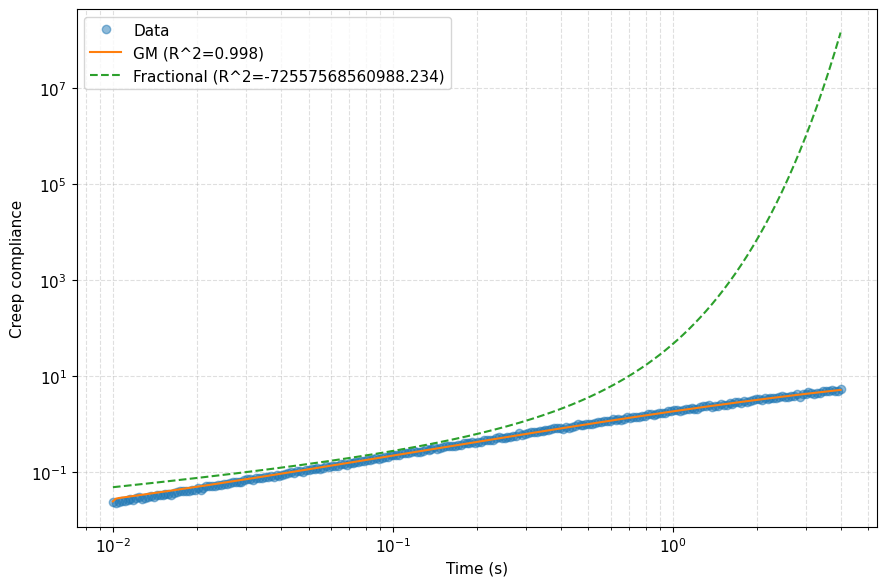

In [5]:
fig, ax = plt.subplots(figsize=(9,6))
ax.loglog(t, J, 'o', label='Data', alpha=0.5)
ax.loglog(t, gm_pred, '-', label=f'GM (R^2={gm_r2:.3f})')
ax.loglog(t, fm_pred, '--', label=f'Fractional (R^2={fm_r2:.3f})')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Creep compliance')
ax.grid(True, which='both', ls='--', alpha=0.4)
ax.legend()
plt.tight_layout()
display(fig)
plt.close(fig)

## Bayesian workflow (NLSQ → best model → NUTS diagnostics)

In [6]:
# Helper functions for workflow
if 'r2_complex' not in globals():
    def r2_complex(y_true, y_pred):
        """Compute R² for complex-valued data."""
        y_true = np.asarray(y_true)
        y_pred = np.asarray(y_pred)
        ss_res = np.sum(np.abs(y_true - y_pred) ** 2)
        ss_tot = np.sum(np.abs(y_true - np.mean(y_true)) ** 2)
        return 1 - ss_res / ss_tot

if '_coerce_pred' not in globals():
    def _coerce_pred(pred):
        """Convert 2-column real array to complex if needed."""
        arr = np.asarray(pred)
        if arr.ndim == 2 and arr.shape[1] == 2 and not np.iscomplexobj(arr):
            arr = arr[:, 0] + 1j * arr[:, 1]
        return arr

NUTS_CONFIG = dict(num_chains=1, num_warmup=200, num_samples=500)  # Fast demo mode


In [7]:
def _detect_datasets():
    """Auto-detect datasets from global variables."""
    datasets = []
    if 'G_star' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': G_star, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    elif 'Gp' in globals() and 'Gpp' in globals() and 'omega' in globals():
        datasets.append({
            'X': omega, 'y': Gp + 1j * Gpp, 'test_mode': 'oscillation',
            'x_label': 'Angular frequency (rad/s)', 'y_label': 'Complex modulus',
        })
    if 'master' in globals() and hasattr(master, 'x') and hasattr(master, 'y'):
        test_mode = master.metadata.get('test_mode', 'oscillation') if hasattr(master, 'metadata') else 'oscillation'
        datasets.append({
            'X': master.x, 'y': master.y, 'test_mode': test_mode,
            'x_label': 'Shifted frequency', 'y_label': 'Mastercurve modulus',
        })
    if 't' in globals() and 'G' in globals():
        datasets.append({'X': t, 'y': G, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'E_t' in globals():
        datasets.append({'X': t, 'y': E_t, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Relaxation modulus'})
    if 't' in globals() and 'sigma' in globals():
        datasets.append({'X': t, 'y': sigma, 'test_mode': 'relaxation', 'x_label': 'Time (s)', 'y_label': 'Stress (Pa)'})
    if 't' in globals() and 'J' in globals():
        datasets.append({'X': t, 'y': J, 'test_mode': 'creep', 'x_label': 'Time (s)', 'y_label': 'Creep compliance'})
    if 'all_df' in globals() and hasattr(all_df, 'columns') and 'phi' in all_df.columns:
        for phi, frame in all_df.groupby('phi'):
            x_vals = frame.iloc[:, 0].to_numpy()
            y_vals = frame.iloc[:, 1].to_numpy()
            datasets.append({
                'X': x_vals, 'y': y_vals, 'test_mode': 'rotation',
                'x_label': f'Shear rate 1/s (phi={phi})', 'y_label': 'Stress (Pa)', 'label': f'phi={phi}',
            })
    if not datasets:
        raise ValueError('No datasets detected; ensure data variables are defined.')
    return datasets

def _collect_candidate_models():
    """Collect candidate models from global variables."""
    if 'candidates' in globals() and isinstance(candidates, (list, tuple)) and candidates:
        return candidates
    models = []
    for name, obj in globals().items():
        if isinstance(obj, type):
            continue
        if hasattr(obj, 'fit_bayesian') and hasattr(obj, 'predict'):
            models.append((name, obj))
    if not models:
        raise ValueError('No candidate models found; define models before running.')
    return models

datasets = _detect_datasets()
model_entries = _collect_candidate_models()
print(f"Found {len(datasets)} dataset(s) and {len(model_entries)} model(s)")


Found 1 dataset(s) and 2 model(s)


In [8]:
# NLSQ fitting loop - fit all models to all datasets
all_fits = {}  # {dataset_idx: [fit_records]}

for ds_idx, ds in enumerate(datasets):
    fits = []
    for name, model in model_entries:
        fitted_model = model
        fit_kwargs = {'test_mode': ds['test_mode'], 'use_log_residuals': True}
        try:
            fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
        except TypeError:
            fit_kwargs.pop('use_log_residuals', None)
            try:
                fitted_model.fit(ds['X'], ds['y'], **fit_kwargs)
            except Exception as exc:
                print(f"Skipping {name} due to fit error: {exc}")
                continue
        except Exception as exc:
            print(f"Skipping {name} due to fit error: {exc}")
            continue

        predict_kwargs = {'test_mode': ds['test_mode']} if 'test_mode' in fit_kwargs else {}
        try:
            pred = _coerce_pred(fitted_model.predict(ds['X'], **predict_kwargs))
        except Exception as exc:
            print(f"Skipping {name} due to predict error: {exc}")
            continue

        try:
            r2_val = r2_complex(ds['y'], pred) if np.iscomplexobj(ds['y']) else fitted_model.score(ds['X'], ds['y'])
        except Exception as exc:
            print(f"Skipping {name} due to scoring error: {exc}")
            continue

        fits.append({'name': name, 'model': fitted_model, 'pred': pred, 'r2': float(r2_val)})

    fits.sort(key=lambda rec: rec['r2'], reverse=True)
    all_fits[ds_idx] = fits
    if fits:
        print(f"Dataset {ds_idx} ranking: {[(r['name'], round(r['r2'], 3)) for r in fits]}")
    else:
        print(f"Dataset {ds_idx}: No successful fits")


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=1.043412s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=25 | final_cost=0.4444 | elapsed=1.043s | final_gradient_norm=2.0842e+05


ERROR:rheojax.core.base:Predict failed
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/core/base.py", line 539, in predict
    result = self._predict(X, **kwargs)
TypeError: GeneralizedMaxwell._predict() got an unexpected keyword argument 'test_mode'


INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=4 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


Skipping gm due to predict error: GeneralizedMaxwell._predict() got an unexpected keyword argument 'test_mode'


[WARNING] Inner optimization loop hit iteration limit inner_iterations=100 | actual_reduction=-1


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=2.048847s


INFO:nlsq.least_squares:Convergence reason=Inner optimization loop exceeded maximum iterations. | iterations=1 | final_cost=6.2523e+14 | elapsed=2.049s | final_gradient_norm=nan


ERROR:rheojax.utils.optimization:Failed to compute covariance from Jacobian
Traceback (most recent call last):
  File "/Users/b80985/Projects/rheojax/rheojax/utils/optimization.py", line 87, in compute_covariance_from_jacobian
    U, s, VT = np.linalg.svd(jac, full_matrices=False)
               ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py", line 1862, in svd
    u, s, vh = gufunc(a, signature=signature)
               ~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/b80985/Projects/rheojax/.venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py", line 172, in _raise_linalgerror_svd_nonconvergence
    raise LinAlgError("SVD did not converge")
numpy.linalg.LinAlgError: SVD did not converge


Dataset 0 ranking: [('fm', -35.862)]


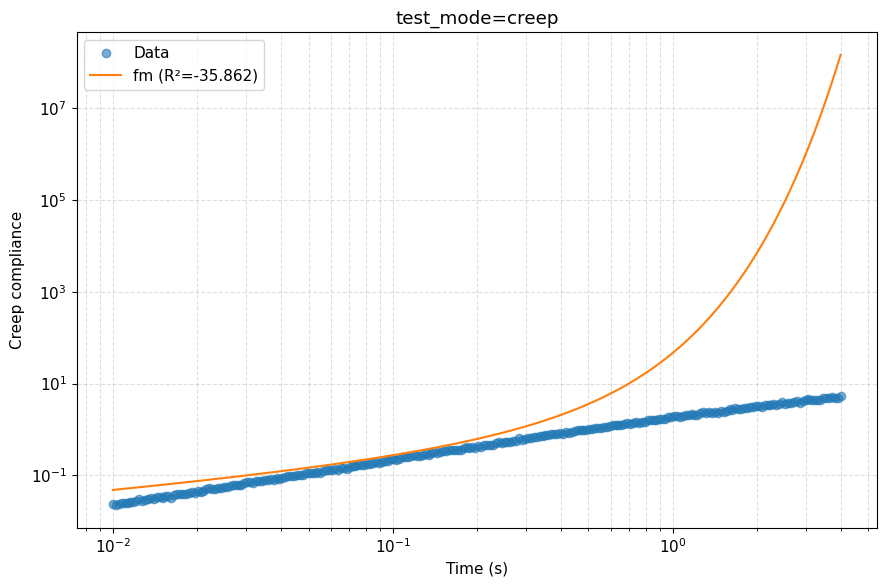

  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<08:32,  1.36it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   2%|▏         | 11/700 [00:00<00:39, 17.30it/s, 1 steps of size 6.38e-12. acc. prob=0.18]

warmup:   2%|▏         | 17/700 [00:00<00:28, 23.88it/s, 3 steps of size 1.94e-11. acc. prob=0.47]

warmup:   3%|▎         | 24/700 [00:01<00:21, 31.06it/s, 15 steps of size 1.09e-10. acc. prob=0.62]

warmup:   4%|▍         | 30/700 [00:01<00:18, 37.15it/s, 3 steps of size 4.49e-10. acc. prob=0.70] 

warmup:   5%|▌         | 36/700 [00:01<00:16, 39.46it/s, 1 steps of size 1.63e-09. acc. prob=0.75]

warmup:   6%|▌         | 42/700 [00:01<00:15, 43.02it/s, 1 steps of size 5.15e-09. acc. prob=0.79]

warmup:   7%|▋         | 48/700 [00:01<00:18, 36.18it/s, 1 steps of size 1.30e-08. acc. prob=0.81]

warmup:   8%|▊         | 53/700 [00:01<00:19, 33.54it/s, 3 steps of size 2.54e-08. acc. prob=0.83]

warmup:   9%|▊         | 60/700 [00:02<00:17, 35.98it/s, 15 steps of size 6.86e-08. acc. prob=0.85]

warmup:   9%|▉         | 64/700 [00:02<00:20, 31.11it/s, 3 steps of size 1.15e-07. acc. prob=0.86] 

warmup:  10%|▉         | 68/700 [00:02<00:24, 25.68it/s, 1 steps of size 1.65e-07. acc. prob=0.87]

warmup:  10%|█         | 72/700 [00:02<00:22, 27.80it/s, 1 steps of size 2.62e-07. acc. prob=0.87]

warmup:  11%|█         | 77/700 [00:02<00:21, 29.47it/s, 6 steps of size 2.57e-07. acc. prob=0.88]

warmup:  12%|█▏        | 82/700 [00:02<00:18, 33.62it/s, 3 steps of size 4.32e-07. acc. prob=0.88]

warmup:  13%|█▎        | 88/700 [00:02<00:15, 39.47it/s, 1 steps of size 6.02e-08. acc. prob=0.88]

warmup:  14%|█▎        | 95/700 [00:03<00:13, 45.25it/s, 1 steps of size 1.98e-08. acc. prob=0.88]

warmup:  14%|█▍        | 101/700 [00:03<00:14, 41.80it/s, 15 steps of size 7.36e-08. acc. prob=0.88]

warmup:  15%|█▌        | 106/700 [00:03<00:14, 39.99it/s, 7 steps of size 8.68e-08. acc. prob=0.88] 

warmup:  16%|█▌        | 111/700 [00:03<00:22, 26.12it/s, 31 steps of size 9.24e-08. acc. prob=0.89]

warmup:  17%|█▋        | 117/700 [00:03<00:18, 31.18it/s, 3 steps of size 1.10e-07. acc. prob=0.89] 

warmup:  18%|█▊        | 123/700 [00:03<00:15, 36.23it/s, 3 steps of size 1.28e-07. acc. prob=0.90]

warmup:  18%|█▊        | 128/700 [00:04<00:17, 32.97it/s, 7 steps of size 6.08e-08. acc. prob=0.90]

warmup:  19%|█▉        | 132/700 [00:04<00:18, 30.94it/s, 3 steps of size 5.05e-08. acc. prob=0.90]

warmup:  19%|█▉        | 136/700 [00:04<00:18, 30.51it/s, 7 steps of size 5.67e-08. acc. prob=0.90]

warmup:  20%|██        | 141/700 [00:04<00:16, 33.83it/s, 3 steps of size 6.49e-08. acc. prob=0.91]

warmup:  21%|██        | 146/700 [00:04<00:16, 33.84it/s, 10 steps of size 1.27e-08. acc. prob=0.91]

warmup:  21%|██▏       | 150/700 [00:04<00:23, 23.85it/s, 15 steps of size 7.53e-09. acc. prob=0.91]

warmup:  22%|██▏       | 153/700 [00:05<00:29, 18.45it/s, 8 steps of size 2.20e-08. acc. prob=0.91] 

warmup:  22%|██▏       | 156/700 [00:05<00:33, 16.46it/s, 24 steps of size 1.06e-08. acc. prob=0.91]

warmup:  23%|██▎       | 159/700 [00:05<00:34, 15.88it/s, 3 steps of size 3.14e-09. acc. prob=0.90] 

warmup:  23%|██▎       | 161/700 [00:05<00:35, 15.06it/s, 6 steps of size 1.70e-09. acc. prob=0.90]

warmup:  23%|██▎       | 163/700 [00:06<01:09,  7.74it/s, 58 steps of size 1.19e-09. acc. prob=0.90]

warmup:  24%|██▎       | 165/700 [00:06<00:59,  9.05it/s, 10 steps of size 6.92e-10. acc. prob=0.90]

warmup:  24%|██▍       | 167/700 [00:07<01:50,  4.80it/s, 18 steps of size 6.39e-10. acc. prob=0.91]

warmup:  24%|██▍       | 169/700 [00:09<03:02,  2.92it/s, 59 steps of size 6.65e-10. acc. prob=0.91]

warmup:  24%|██▍       | 170/700 [00:09<03:45,  2.35it/s, 90 steps of size 6.89e-10. acc. prob=0.91]

warmup:  24%|██▍       | 171/700 [00:10<04:13,  2.09it/s, 73 steps of size 7.09e-10. acc. prob=0.91]

warmup:  25%|██▍       | 172/700 [00:10<03:40,  2.39it/s, 30 steps of size 6.88e-10. acc. prob=0.91]

warmup:  25%|██▍       | 173/700 [00:11<03:59,  2.20it/s, 50 steps of size 6.96e-10. acc. prob=0.91]

warmup:  25%|██▍       | 174/700 [00:13<07:40,  1.14it/s, 167 steps of size 7.33e-10. acc. prob=0.91]

warmup:  25%|██▌       | 175/700 [00:15<10:08,  1.16s/it, 149 steps of size 7.69e-10. acc. prob=0.91]

warmup:  25%|██▌       | 176/700 [00:16<09:00,  1.03s/it, 60 steps of size 7.85e-10. acc. prob=0.91] 

warmup:  25%|██▌       | 177/700 [00:16<07:30,  1.16it/s, 50 steps of size 7.93e-10. acc. prob=0.91]

warmup:  25%|██▌       | 178/700 [00:17<06:38,  1.31it/s, 63 steps of size 8.48e-10. acc. prob=0.91]

warmup:  26%|██▌       | 179/700 [00:18<08:32,  1.02it/s, 134 steps of size 8.87e-10. acc. prob=0.91]

warmup:  26%|██▌       | 180/700 [00:19<09:08,  1.05s/it, 91 steps of size 9.18e-10. acc. prob=0.91] 

warmup:  26%|██▌       | 181/700 [00:21<10:04,  1.16s/it, 106 steps of size 9.53e-10. acc. prob=0.91]

warmup:  26%|██▌       | 182/700 [00:22<09:28,  1.10s/it, 87 steps of size 9.84e-10. acc. prob=0.91] 

warmup:  26%|██▌       | 183/700 [00:22<08:04,  1.07it/s, 62 steps of size 1.00e-09. acc. prob=0.91]

warmup:  26%|██▋       | 184/700 [00:23<07:27,  1.15it/s, 94 steps of size 1.04e-09. acc. prob=0.91]

warmup:  26%|██▋       | 185/700 [00:24<07:06,  1.21it/s, 86 steps of size 1.07e-09. acc. prob=0.91]

warmup:  27%|██▋       | 186/700 [00:24<06:41,  1.28it/s, 82 steps of size 1.10e-09. acc. prob=0.91]

warmup:  27%|██▋       | 187/700 [00:25<06:37,  1.29it/s, 93 steps of size 1.13e-09. acc. prob=0.91]

warmup:  27%|██▋       | 188/700 [00:26<05:47,  1.47it/s, 80 steps of size 1.16e-09. acc. prob=0.91]

warmup:  27%|██▋       | 189/700 [00:26<04:35,  1.86it/s, 36 steps of size 1.15e-09. acc. prob=0.91]

warmup:  27%|██▋       | 190/700 [00:26<04:26,  1.91it/s, 76 steps of size 1.17e-09. acc. prob=0.92]

warmup:  27%|██▋       | 191/700 [00:27<05:52,  1.44it/s, 131 steps of size 1.22e-09. acc. prob=0.92]

warmup:  27%|██▋       | 192/700 [00:29<09:00,  1.06s/it, 154 steps of size 1.27e-09. acc. prob=0.92]

warmup:  28%|██▊       | 193/700 [00:33<14:41,  1.74s/it, 194 steps of size 1.32e-09. acc. prob=0.92]

warmup:  28%|██▊       | 194/700 [00:34<14:35,  1.73s/it, 127 steps of size 1.39e-09. acc. prob=0.92]

warmup:  28%|██▊       | 195/700 [00:37<16:08,  1.92s/it, 129 steps of size 1.44e-09. acc. prob=0.92]

warmup:  28%|██▊       | 196/700 [00:38<13:12,  1.57s/it, 65 steps of size 1.46e-09. acc. prob=0.92] 

warmup:  28%|██▊       | 197/700 [00:38<09:38,  1.15s/it, 31 steps of size 1.54e-09. acc. prob=0.92]

warmup:  28%|██▊       | 198/700 [00:38<08:15,  1.01it/s, 69 steps of size 1.56e-09. acc. prob=0.92]

warmup:  28%|██▊       | 199/700 [00:39<06:18,  1.32it/s, 34 steps of size 1.53e-09. acc. prob=0.92]

warmup:  29%|██▊       | 200/700 [00:40<07:19,  1.14it/s, 127 steps of size 1.20e-09. acc. prob=0.92]

sample:  29%|██▊       | 201/700 [00:41<09:12,  1.11s/it, 143 steps of size 1.20e-09. acc. prob=0.99]

sample:  29%|██▉       | 202/700 [00:42<08:20,  1.01s/it, 61 steps of size 1.20e-09. acc. prob=0.99] 

sample:  29%|██▉       | 203/700 [00:43<08:02,  1.03it/s, 86 steps of size 1.20e-09. acc. prob=0.99]

sample:  29%|██▉       | 204/700 [00:44<08:59,  1.09s/it, 144 steps of size 1.20e-09. acc. prob=0.99]

sample:  29%|██▉       | 205/700 [00:45<07:26,  1.11it/s, 55 steps of size 1.20e-09. acc. prob=0.99] 

sample:  29%|██▉       | 206/700 [00:46<08:58,  1.09s/it, 151 steps of size 1.20e-09. acc. prob=0.99]

sample:  30%|██▉       | 207/700 [00:48<10:43,  1.30s/it, 205 steps of size 1.20e-09. acc. prob=0.99]

sample:  30%|██▉       | 208/700 [00:49<09:31,  1.16s/it, 97 steps of size 1.20e-09. acc. prob=0.99] 

sample:  30%|██▉       | 209/700 [00:50<08:08,  1.00it/s, 75 steps of size 1.20e-09. acc. prob=0.99]

sample:  30%|███       | 210/700 [00:50<05:59,  1.36it/s, 23 steps of size 1.20e-09. acc. prob=0.99]

sample:  30%|███       | 211/700 [00:50<04:52,  1.67it/s, 45 steps of size 1.20e-09. acc. prob=0.99]

sample:  30%|███       | 212/700 [00:50<04:20,  1.87it/s, 36 steps of size 1.20e-09. acc. prob=0.98]

sample:  30%|███       | 213/700 [00:51<04:42,  1.72it/s, 80 steps of size 1.20e-09. acc. prob=0.98]

sample:  31%|███       | 214/700 [00:52<05:27,  1.48it/s, 111 steps of size 1.20e-09. acc. prob=0.98]

sample:  31%|███       | 215/700 [00:52<05:01,  1.61it/s, 62 steps of size 1.20e-09. acc. prob=0.98] 

sample:  31%|███       | 216/700 [00:54<06:25,  1.25it/s, 133 steps of size 1.20e-09. acc. prob=0.99]

sample:  31%|███       | 217/700 [00:55<06:32,  1.23it/s, 93 steps of size 1.20e-09. acc. prob=0.99] 

sample:  31%|███       | 218/700 [00:56<07:37,  1.05it/s, 141 steps of size 1.20e-09. acc. prob=0.99]

sample:  31%|███▏      | 219/700 [00:56<06:51,  1.17it/s, 64 steps of size 1.20e-09. acc. prob=0.99] 

sample:  31%|███▏      | 220/700 [00:57<06:00,  1.33it/s, 58 steps of size 1.20e-09. acc. prob=0.99]

sample:  32%|███▏      | 221/700 [00:57<04:45,  1.68it/s, 35 steps of size 1.20e-09. acc. prob=0.99]

sample:  32%|███▏      | 223/700 [00:58<04:36,  1.72it/s, 100 steps of size 1.20e-09. acc. prob=0.98]

sample:  32%|███▏      | 224/700 [01:00<06:07,  1.29it/s, 90 steps of size 1.20e-09. acc. prob=0.98] 

sample:  32%|███▏      | 225/700 [01:01<07:34,  1.05it/s, 87 steps of size 1.20e-09. acc. prob=0.98]

sample:  32%|███▏      | 226/700 [01:02<07:40,  1.03it/s, 109 steps of size 1.20e-09. acc. prob=0.98]

sample:  32%|███▏      | 227/700 [01:02<06:07,  1.29it/s, 41 steps of size 1.20e-09. acc. prob=0.98] 

sample:  33%|███▎      | 228/700 [01:03<04:37,  1.70it/s, 21 steps of size 1.20e-09. acc. prob=0.98]

sample:  33%|███▎      | 230/700 [01:03<02:50,  2.75it/s, 15 steps of size 1.20e-09. acc. prob=0.98]

sample:  33%|███▎      | 231/700 [01:03<03:29,  2.23it/s, 64 steps of size 1.20e-09. acc. prob=0.98]

sample:  33%|███▎      | 232/700 [01:04<04:01,  1.93it/s, 67 steps of size 1.20e-09. acc. prob=0.98]

sample:  33%|███▎      | 233/700 [01:05<05:15,  1.48it/s, 113 steps of size 1.20e-09. acc. prob=0.98]

sample:  33%|███▎      | 234/700 [01:07<06:59,  1.11it/s, 140 steps of size 1.20e-09. acc. prob=0.98]

sample:  34%|███▎      | 235/700 [01:08<07:06,  1.09it/s, 87 steps of size 1.20e-09. acc. prob=0.98] 

sample:  34%|███▎      | 236/700 [01:08<06:48,  1.13it/s, 75 steps of size 1.20e-09. acc. prob=0.98]

sample:  34%|███▍      | 237/700 [01:09<05:59,  1.29it/s, 54 steps of size 1.20e-09. acc. prob=0.98]

sample:  34%|███▍      | 238/700 [01:10<06:20,  1.21it/s, 77 steps of size 1.20e-09. acc. prob=0.98]

sample:  34%|███▍      | 239/700 [01:11<06:15,  1.23it/s, 69 steps of size 1.20e-09. acc. prob=0.98]

sample:  34%|███▍      | 240/700 [01:11<05:10,  1.48it/s, 43 steps of size 1.20e-09. acc. prob=0.98]

sample:  34%|███▍      | 241/700 [01:12<04:38,  1.65it/s, 51 steps of size 1.20e-09. acc. prob=0.98]

sample:  35%|███▍      | 242/700 [01:12<03:37,  2.11it/s, 28 steps of size 1.20e-09. acc. prob=0.98]

sample:  35%|███▍      | 243/700 [01:12<03:50,  1.98it/s, 55 steps of size 1.20e-09. acc. prob=0.98]

sample:  35%|███▍      | 244/700 [01:13<04:18,  1.77it/s, 64 steps of size 1.20e-09. acc. prob=0.98]

sample:  35%|███▌      | 245/700 [01:13<03:28,  2.19it/s, 26 steps of size 1.20e-09. acc. prob=0.98]

sample:  35%|███▌      | 247/700 [01:13<02:05,  3.61it/s, 6 steps of size 1.20e-09. acc. prob=0.98] 

sample:  36%|███▌      | 250/700 [01:14<01:32,  4.88it/s, 36 steps of size 1.20e-09. acc. prob=0.97]

sample:  36%|███▌      | 251/700 [01:14<02:07,  3.51it/s, 69 steps of size 1.20e-09. acc. prob=0.97]

sample:  36%|███▌      | 252/700 [01:15<03:14,  2.30it/s, 80 steps of size 1.20e-09. acc. prob=0.97]

sample:  36%|███▌      | 253/700 [01:16<02:52,  2.60it/s, 27 steps of size 1.20e-09. acc. prob=0.97]

sample:  36%|███▋      | 255/700 [01:16<02:05,  3.56it/s, 23 steps of size 1.20e-09. acc. prob=0.97]

sample:  37%|███▋      | 257/700 [01:16<01:34,  4.69it/s, 18 steps of size 1.20e-09. acc. prob=0.97]

sample:  37%|███▋      | 258/700 [01:16<01:28,  4.97it/s, 24 steps of size 1.20e-09. acc. prob=0.97]

sample:  37%|███▋      | 260/700 [01:17<02:12,  3.31it/s, 70 steps of size 1.20e-09. acc. prob=0.96]

sample:  37%|███▋      | 261/700 [01:18<02:58,  2.47it/s, 71 steps of size 1.20e-09. acc. prob=0.96]

sample:  37%|███▋      | 262/700 [01:18<02:50,  2.57it/s, 34 steps of size 1.20e-09. acc. prob=0.96]

sample:  38%|███▊      | 268/700 [01:18<01:02,  6.93it/s, 10 steps of size 1.20e-09. acc. prob=0.93]

sample:  39%|███▊      | 270/700 [01:21<03:18,  2.16it/s, 77 steps of size 1.20e-09. acc. prob=0.93]

sample:  39%|███▉      | 272/700 [01:23<03:46,  1.89it/s, 55 steps of size 1.20e-09. acc. prob=0.93]

sample:  39%|███▉      | 273/700 [01:23<03:47,  1.88it/s, 70 steps of size 1.20e-09. acc. prob=0.93]

sample:  39%|███▉      | 274/700 [01:23<03:17,  2.16it/s, 26 steps of size 1.20e-09. acc. prob=0.93]

sample:  39%|███▉      | 275/700 [01:24<03:04,  2.31it/s, 42 steps of size 1.20e-09. acc. prob=0.93]

sample:  39%|███▉      | 276/700 [01:24<03:08,  2.25it/s, 54 steps of size 1.20e-09. acc. prob=0.93]

sample:  40%|███▉      | 277/700 [01:25<03:20,  2.11it/s, 63 steps of size 1.20e-09. acc. prob=0.93]

sample:  40%|███▉      | 278/700 [01:26<04:34,  1.54it/s, 87 steps of size 1.20e-09. acc. prob=0.94]

sample:  40%|███▉      | 279/700 [01:26<03:43,  1.89it/s, 30 steps of size 1.20e-09. acc. prob=0.94]

sample:  40%|████      | 280/700 [01:27<04:08,  1.69it/s, 73 steps of size 1.20e-09. acc. prob=0.94]

sample:  40%|████      | 281/700 [01:28<05:06,  1.37it/s, 111 steps of size 1.20e-09. acc. prob=0.94]

sample:  40%|████      | 282/700 [01:29<04:43,  1.47it/s, 69 steps of size 1.20e-09. acc. prob=0.94] 

sample:  40%|████      | 283/700 [01:29<04:24,  1.58it/s, 57 steps of size 1.20e-09. acc. prob=0.94]

sample:  41%|████      | 284/700 [01:30<04:20,  1.60it/s, 65 steps of size 1.20e-09. acc. prob=0.94]

sample:  41%|████      | 285/700 [01:30<03:26,  2.01it/s, 21 steps of size 1.20e-09. acc. prob=0.94]

sample:  41%|████      | 286/700 [01:30<02:51,  2.42it/s, 18 steps of size 1.20e-09. acc. prob=0.94]

sample:  41%|████      | 288/700 [01:31<02:21,  2.91it/s, 35 steps of size 1.20e-09. acc. prob=0.94]

sample:  41%|████▏     | 289/700 [01:31<02:45,  2.49it/s, 37 steps of size 1.20e-09. acc. prob=0.94]

sample:  41%|████▏     | 290/700 [01:32<02:47,  2.45it/s, 26 steps of size 1.20e-09. acc. prob=0.94]

sample:  42%|████▏     | 291/700 [01:32<03:40,  1.86it/s, 42 steps of size 1.20e-09. acc. prob=0.94]

sample:  42%|████▏     | 292/700 [01:33<03:21,  2.03it/s, 22 steps of size 1.20e-09. acc. prob=0.94]

sample:  42%|████▏     | 293/700 [01:33<02:53,  2.34it/s, 27 steps of size 1.20e-09. acc. prob=0.94]

sample:  42%|████▏     | 294/700 [01:33<02:38,  2.57it/s, 30 steps of size 1.20e-09. acc. prob=0.94]

sample:  42%|████▏     | 296/700 [01:34<01:54,  3.51it/s, 29 steps of size 1.20e-09. acc. prob=0.94]

sample:  43%|████▎     | 298/700 [01:34<01:30,  4.46it/s, 18 steps of size 1.20e-09. acc. prob=0.94]

sample:  43%|████▎     | 304/700 [01:34<00:37, 10.48it/s, 3 steps of size 1.20e-09. acc. prob=0.92] 

sample:  44%|████▍     | 310/700 [01:34<00:23, 16.25it/s, 4 steps of size 1.20e-09. acc. prob=0.90]

sample:  45%|████▍     | 313/700 [01:34<00:21, 17.66it/s, 4 steps of size 1.20e-09. acc. prob=0.90]

sample:  45%|████▌     | 316/700 [01:35<00:53,  7.24it/s, 38 steps of size 1.20e-09. acc. prob=0.90]

sample:  45%|████▌     | 318/700 [01:36<01:01,  6.20it/s, 34 steps of size 1.20e-09. acc. prob=0.90]

sample:  46%|████▌     | 320/700 [01:36<01:02,  6.03it/s, 15 steps of size 1.20e-09. acc. prob=0.90]

sample:  46%|████▌     | 322/700 [01:37<01:16,  4.93it/s, 16 steps of size 1.20e-09. acc. prob=0.90]

sample:  46%|████▋     | 325/700 [01:37<00:57,  6.49it/s, 16 steps of size 1.20e-09. acc. prob=0.89]

sample:  47%|████▋     | 327/700 [01:38<01:15,  4.95it/s, 54 steps of size 1.20e-09. acc. prob=0.89]

sample:  47%|████▋     | 328/700 [01:38<01:09,  5.33it/s, 19 steps of size 1.20e-09. acc. prob=0.90]

sample:  47%|████▋     | 330/700 [01:39<01:26,  4.29it/s, 59 steps of size 1.20e-09. acc. prob=0.90]

sample:  47%|████▋     | 331/700 [01:39<01:18,  4.73it/s, 14 steps of size 1.20e-09. acc. prob=0.90]

sample:  48%|████▊     | 333/700 [01:39<00:59,  6.12it/s, 10 steps of size 1.20e-09. acc. prob=0.90]

sample:  48%|████▊     | 334/700 [01:39<00:55,  6.61it/s, 18 steps of size 1.20e-09. acc. prob=0.90]

sample:  48%|████▊     | 335/700 [01:39<00:56,  6.49it/s, 24 steps of size 1.20e-09. acc. prob=0.90]

sample:  48%|████▊     | 336/700 [01:40<01:21,  4.48it/s, 47 steps of size 1.20e-09. acc. prob=0.90]

sample:  48%|████▊     | 337/700 [01:40<01:12,  4.99it/s, 23 steps of size 1.20e-09. acc. prob=0.90]

sample:  48%|████▊     | 338/700 [01:40<01:03,  5.69it/s, 15 steps of size 1.20e-09. acc. prob=0.90]

sample:  49%|████▊     | 340/700 [01:40<01:06,  5.42it/s, 30 steps of size 1.20e-09. acc. prob=0.90]

sample:  49%|████▊     | 341/700 [01:41<02:09,  2.78it/s, 64 steps of size 1.20e-09. acc. prob=0.90]

sample:  49%|████▉     | 342/700 [01:43<03:40,  1.62it/s, 109 steps of size 1.20e-09. acc. prob=0.90]

sample:  49%|████▉     | 343/700 [01:44<04:21,  1.36it/s, 91 steps of size 1.20e-09. acc. prob=0.90] 

sample:  49%|████▉     | 344/700 [01:45<04:38,  1.28it/s, 100 steps of size 1.20e-09. acc. prob=0.90]

sample:  49%|████▉     | 345/700 [01:45<03:52,  1.53it/s, 38 steps of size 1.20e-09. acc. prob=0.90] 

sample:  49%|████▉     | 346/700 [01:45<03:21,  1.76it/s, 55 steps of size 1.20e-09. acc. prob=0.90]

sample:  50%|████▉     | 347/700 [01:46<03:18,  1.78it/s, 50 steps of size 1.20e-09. acc. prob=0.90]

sample:  50%|████▉     | 348/700 [01:46<03:04,  1.91it/s, 28 steps of size 1.20e-09. acc. prob=0.90]

sample:  50%|████▉     | 349/700 [01:47<02:49,  2.07it/s, 26 steps of size 1.20e-09. acc. prob=0.90]

sample:  50%|█████     | 350/700 [01:47<03:00,  1.94it/s, 39 steps of size 1.20e-09. acc. prob=0.90]

sample:  50%|█████     | 351/700 [01:47<02:22,  2.46it/s, 15 steps of size 1.20e-09. acc. prob=0.90]

sample:  50%|█████     | 352/700 [01:47<01:51,  3.11it/s, 20 steps of size 1.20e-09. acc. prob=0.91]

sample:  50%|█████     | 353/700 [01:49<03:41,  1.56it/s, 69 steps of size 1.20e-09. acc. prob=0.91]

sample:  51%|█████     | 354/700 [01:50<04:54,  1.18it/s, 128 steps of size 1.20e-09. acc. prob=0.91]

sample:  51%|█████     | 355/700 [01:51<05:07,  1.12it/s, 114 steps of size 1.20e-09. acc. prob=0.91]

sample:  51%|█████     | 356/700 [01:52<04:43,  1.21it/s, 84 steps of size 1.20e-09. acc. prob=0.91] 

sample:  51%|█████     | 357/700 [01:53<05:00,  1.14it/s, 127 steps of size 1.20e-09. acc. prob=0.91]

sample:  51%|█████     | 358/700 [01:55<07:08,  1.25s/it, 144 steps of size 1.20e-09. acc. prob=0.91]

sample:  51%|█████▏    | 359/700 [01:56<06:52,  1.21s/it, 55 steps of size 1.20e-09. acc. prob=0.91] 

sample:  51%|█████▏    | 360/700 [01:57<06:52,  1.21s/it, 81 steps of size 1.20e-09. acc. prob=0.91]

sample:  52%|█████▏    | 361/700 [01:58<06:47,  1.20s/it, 97 steps of size 1.20e-09. acc. prob=0.91]

sample:  52%|█████▏    | 362/700 [01:59<05:57,  1.06s/it, 81 steps of size 1.20e-09. acc. prob=0.91]

sample:  52%|█████▏    | 363/700 [02:00<05:01,  1.12it/s, 47 steps of size 1.20e-09. acc. prob=0.91]

sample:  52%|█████▏    | 364/700 [02:01<05:22,  1.04it/s, 89 steps of size 1.20e-09. acc. prob=0.91]

sample:  52%|█████▏    | 365/700 [02:03<06:44,  1.21s/it, 144 steps of size 1.20e-09. acc. prob=0.91]

sample:  52%|█████▏    | 366/700 [02:04<07:07,  1.28s/it, 116 steps of size 1.20e-09. acc. prob=0.91]

sample:  52%|█████▏    | 367/700 [02:05<06:44,  1.22s/it, 104 steps of size 1.20e-09. acc. prob=0.91]

sample:  53%|█████▎    | 368/700 [02:06<06:34,  1.19s/it, 109 steps of size 1.20e-09. acc. prob=0.91]

sample:  53%|█████▎    | 369/700 [02:08<08:02,  1.46s/it, 185 steps of size 1.20e-09. acc. prob=0.91]

sample:  53%|█████▎    | 370/700 [02:10<08:44,  1.59s/it, 162 steps of size 1.20e-09. acc. prob=0.91]

sample:  53%|█████▎    | 371/700 [02:12<08:29,  1.55s/it, 127 steps of size 1.20e-09. acc. prob=0.91]

sample:  53%|█████▎    | 372/700 [02:13<08:18,  1.52s/it, 127 steps of size 1.20e-09. acc. prob=0.92]

sample:  53%|█████▎    | 373/700 [02:14<07:44,  1.42s/it, 113 steps of size 1.20e-09. acc. prob=0.92]

sample:  53%|█████▎    | 374/700 [02:15<06:10,  1.14s/it, 48 steps of size 1.20e-09. acc. prob=0.92] 

sample:  54%|█████▎    | 375/700 [02:15<05:24,  1.00it/s, 63 steps of size 1.20e-09. acc. prob=0.92]

sample:  54%|█████▎    | 376/700 [02:16<04:07,  1.31it/s, 28 steps of size 1.20e-09. acc. prob=0.92]

sample:  54%|█████▍    | 377/700 [02:16<03:26,  1.56it/s, 45 steps of size 1.20e-09. acc. prob=0.92]

sample:  54%|█████▍    | 378/700 [02:18<04:58,  1.08it/s, 153 steps of size 1.20e-09. acc. prob=0.92]

sample:  54%|█████▍    | 379/700 [02:19<06:04,  1.13s/it, 158 steps of size 1.20e-09. acc. prob=0.92]

sample:  54%|█████▍    | 380/700 [02:20<05:16,  1.01it/s, 62 steps of size 1.20e-09. acc. prob=0.92] 

sample:  54%|█████▍    | 381/700 [02:22<07:07,  1.34s/it, 157 steps of size 1.20e-09. acc. prob=0.92]

sample:  55%|█████▍    | 382/700 [02:25<09:41,  1.83s/it, 136 steps of size 1.20e-09. acc. prob=0.92]

sample:  55%|█████▍    | 383/700 [02:25<07:30,  1.42s/it, 50 steps of size 1.20e-09. acc. prob=0.92] 

sample:  55%|█████▍    | 384/700 [02:26<05:56,  1.13s/it, 49 steps of size 1.20e-09. acc. prob=0.92]

sample:  55%|█████▌    | 385/700 [02:27<05:33,  1.06s/it, 95 steps of size 1.20e-09. acc. prob=0.92]

sample:  55%|█████▌    | 386/700 [02:28<05:03,  1.03it/s, 69 steps of size 1.20e-09. acc. prob=0.92]

sample:  55%|█████▌    | 387/700 [02:28<03:44,  1.40it/s, 22 steps of size 1.20e-09. acc. prob=0.92]

sample:  55%|█████▌    | 388/700 [02:28<03:28,  1.50it/s, 60 steps of size 1.20e-09. acc. prob=0.92]

sample:  56%|█████▌    | 389/700 [02:29<03:35,  1.44it/s, 81 steps of size 1.20e-09. acc. prob=0.92]

sample:  56%|█████▌    | 390/700 [02:30<03:54,  1.32it/s, 77 steps of size 1.20e-09. acc. prob=0.92]

sample:  56%|█████▌    | 391/700 [02:30<03:13,  1.60it/s, 30 steps of size 1.20e-09. acc. prob=0.92]

sample:  56%|█████▌    | 392/700 [02:31<03:07,  1.64it/s, 51 steps of size 1.20e-09. acc. prob=0.92]

sample:  56%|█████▌    | 393/700 [02:32<03:20,  1.53it/s, 63 steps of size 1.20e-09. acc. prob=0.92]

sample:  56%|█████▋    | 394/700 [02:32<02:51,  1.79it/s, 36 steps of size 1.20e-09. acc. prob=0.92]

sample:  56%|█████▋    | 395/700 [02:32<02:12,  2.30it/s, 19 steps of size 1.20e-09. acc. prob=0.92]

sample:  57%|█████▋    | 396/700 [02:33<02:31,  2.00it/s, 56 steps of size 1.20e-09. acc. prob=0.92]

sample:  57%|█████▋    | 397/700 [02:33<02:14,  2.25it/s, 31 steps of size 1.20e-09. acc. prob=0.92]

sample:  57%|█████▋    | 398/700 [02:33<02:14,  2.24it/s, 58 steps of size 1.20e-09. acc. prob=0.92]

sample:  57%|█████▋    | 399/700 [02:34<02:30,  2.00it/s, 70 steps of size 1.20e-09. acc. prob=0.92]

sample:  57%|█████▋    | 400/700 [02:35<03:06,  1.61it/s, 91 steps of size 1.20e-09. acc. prob=0.92]

sample:  57%|█████▋    | 401/700 [02:36<04:07,  1.21it/s, 128 steps of size 1.20e-09. acc. prob=0.92]

sample:  57%|█████▋    | 402/700 [02:38<04:40,  1.06it/s, 103 steps of size 1.20e-09. acc. prob=0.93]

sample:  58%|█████▊    | 403/700 [02:38<04:03,  1.22it/s, 46 steps of size 1.20e-09. acc. prob=0.93] 

sample:  58%|█████▊    | 404/700 [02:39<03:33,  1.39it/s, 83 steps of size 1.20e-09. acc. prob=0.93]

sample:  58%|█████▊    | 405/700 [02:39<03:09,  1.56it/s, 47 steps of size 1.20e-09. acc. prob=0.93]

sample:  58%|█████▊    | 406/700 [02:39<02:40,  1.83it/s, 31 steps of size 1.20e-09. acc. prob=0.93]

sample:  58%|█████▊    | 407/700 [02:40<02:25,  2.02it/s, 59 steps of size 1.20e-09. acc. prob=0.93]

sample:  58%|█████▊    | 408/700 [02:40<02:22,  2.05it/s, 58 steps of size 1.20e-09. acc. prob=0.93]

sample:  58%|█████▊    | 409/700 [02:41<02:59,  1.63it/s, 81 steps of size 1.20e-09. acc. prob=0.93]

sample:  59%|█████▊    | 410/700 [02:42<02:56,  1.64it/s, 84 steps of size 1.20e-09. acc. prob=0.93]

sample:  59%|█████▊    | 411/700 [02:42<02:18,  2.09it/s, 25 steps of size 1.20e-09. acc. prob=0.93]

sample:  59%|█████▉    | 412/700 [02:42<02:32,  1.89it/s, 54 steps of size 1.20e-09. acc. prob=0.93]

sample:  59%|█████▉    | 413/700 [02:43<02:17,  2.09it/s, 49 steps of size 1.20e-09. acc. prob=0.93]

sample:  59%|█████▉    | 414/700 [02:43<02:12,  2.16it/s, 54 steps of size 1.20e-09. acc. prob=0.93]

sample:  59%|█████▉    | 415/700 [02:44<02:26,  1.95it/s, 50 steps of size 1.20e-09. acc. prob=0.93]

sample:  59%|█████▉    | 416/700 [02:44<01:55,  2.46it/s, 21 steps of size 1.20e-09. acc. prob=0.93]

sample:  60%|█████▉    | 417/700 [02:45<03:02,  1.55it/s, 91 steps of size 1.20e-09. acc. prob=0.93]

sample:  60%|█████▉    | 418/700 [02:46<02:54,  1.61it/s, 48 steps of size 1.20e-09. acc. prob=0.93]

sample:  60%|█████▉    | 419/700 [02:46<02:54,  1.61it/s, 44 steps of size 1.20e-09. acc. prob=0.93]

sample:  60%|██████    | 420/700 [02:47<03:01,  1.54it/s, 45 steps of size 1.20e-09. acc. prob=0.93]

sample:  60%|██████    | 421/700 [02:48<03:08,  1.48it/s, 59 steps of size 1.20e-09. acc. prob=0.93]

sample:  60%|██████    | 422/700 [02:49<03:40,  1.26it/s, 127 steps of size 1.20e-09. acc. prob=0.93]

sample:  60%|██████    | 423/700 [02:50<04:40,  1.01s/it, 127 steps of size 1.20e-09. acc. prob=0.93]

sample:  61%|██████    | 424/700 [02:51<03:43,  1.24it/s, 59 steps of size 1.20e-09. acc. prob=0.93] 

sample:  61%|██████    | 425/700 [02:52<04:16,  1.07it/s, 98 steps of size 1.20e-09. acc. prob=0.93]

sample:  61%|██████    | 426/700 [02:53<04:09,  1.10it/s, 57 steps of size 1.20e-09. acc. prob=0.93]

sample:  61%|██████    | 427/700 [02:53<03:36,  1.26it/s, 45 steps of size 1.20e-09. acc. prob=0.93]

sample:  61%|██████    | 428/700 [02:54<02:51,  1.59it/s, 40 steps of size 1.20e-09. acc. prob=0.93]

sample:  61%|██████▏   | 429/700 [02:54<02:52,  1.57it/s, 63 steps of size 1.20e-09. acc. prob=0.93]

sample:  61%|██████▏   | 430/700 [02:54<02:08,  2.10it/s, 15 steps of size 1.20e-09. acc. prob=0.93]

sample:  62%|██████▏   | 431/700 [02:55<01:38,  2.74it/s, 15 steps of size 1.20e-09. acc. prob=0.93]

sample:  62%|██████▏   | 432/700 [02:55<01:38,  2.72it/s, 47 steps of size 1.20e-09. acc. prob=0.93]

sample:  62%|██████▏   | 433/700 [02:55<01:43,  2.57it/s, 49 steps of size 1.20e-09. acc. prob=0.93]

sample:  62%|██████▏   | 434/700 [02:56<01:48,  2.45it/s, 76 steps of size 1.20e-09. acc. prob=0.93]

sample:  62%|██████▏   | 435/700 [02:57<02:22,  1.86it/s, 87 steps of size 1.20e-09. acc. prob=0.93]

sample:  62%|██████▏   | 436/700 [02:58<03:36,  1.22it/s, 149 steps of size 1.20e-09. acc. prob=0.93]

sample:  62%|██████▏   | 437/700 [02:59<03:55,  1.12it/s, 62 steps of size 1.20e-09. acc. prob=0.93] 

sample:  63%|██████▎   | 438/700 [03:00<03:18,  1.32it/s, 60 steps of size 1.20e-09. acc. prob=0.93]

sample:  63%|██████▎   | 439/700 [03:00<03:06,  1.40it/s, 84 steps of size 1.20e-09. acc. prob=0.93]

sample:  63%|██████▎   | 440/700 [03:01<03:19,  1.30it/s, 133 steps of size 1.20e-09. acc. prob=0.93]

sample:  63%|██████▎   | 441/700 [03:02<03:08,  1.38it/s, 98 steps of size 1.20e-09. acc. prob=0.93] 

sample:  63%|██████▎   | 442/700 [03:02<02:50,  1.51it/s, 72 steps of size 1.20e-09. acc. prob=0.93]

sample:  63%|██████▎   | 443/700 [03:03<03:05,  1.38it/s, 101 steps of size 1.20e-09. acc. prob=0.93]

sample:  63%|██████▎   | 444/700 [03:04<02:56,  1.45it/s, 67 steps of size 1.20e-09. acc. prob=0.93] 

sample:  64%|██████▎   | 445/700 [03:07<05:46,  1.36s/it, 123 steps of size 1.20e-09. acc. prob=0.93]

sample:  64%|██████▎   | 446/700 [03:08<05:34,  1.32s/it, 152 steps of size 1.20e-09. acc. prob=0.94]

sample:  64%|██████▍   | 447/700 [03:08<04:29,  1.06s/it, 53 steps of size 1.20e-09. acc. prob=0.94] 

sample:  64%|██████▍   | 448/700 [03:10<04:49,  1.15s/it, 107 steps of size 1.20e-09. acc. prob=0.94]

sample:  64%|██████▍   | 449/700 [03:11<05:03,  1.21s/it, 129 steps of size 1.20e-09. acc. prob=0.94]

sample:  64%|██████▍   | 450/700 [03:13<05:51,  1.41s/it, 146 steps of size 1.20e-09. acc. prob=0.94]

sample:  64%|██████▍   | 451/700 [03:14<05:13,  1.26s/it, 106 steps of size 1.20e-09. acc. prob=0.94]

sample:  65%|██████▍   | 452/700 [03:14<04:09,  1.01s/it, 61 steps of size 1.20e-09. acc. prob=0.94] 

sample:  65%|██████▍   | 453/700 [03:15<03:35,  1.15it/s, 69 steps of size 1.20e-09. acc. prob=0.94]

sample:  65%|██████▍   | 454/700 [03:15<03:09,  1.30it/s, 51 steps of size 1.20e-09. acc. prob=0.94]

sample:  65%|██████▌   | 455/700 [03:16<03:09,  1.29it/s, 90 steps of size 1.20e-09. acc. prob=0.94]

sample:  65%|██████▌   | 456/700 [03:16<02:27,  1.65it/s, 29 steps of size 1.20e-09. acc. prob=0.94]

sample:  65%|██████▌   | 457/700 [03:17<02:18,  1.75it/s, 60 steps of size 1.20e-09. acc. prob=0.94]

sample:  65%|██████▌   | 458/700 [03:17<02:08,  1.88it/s, 28 steps of size 1.20e-09. acc. prob=0.94]

sample:  66%|██████▌   | 459/700 [03:18<02:09,  1.86it/s, 81 steps of size 1.20e-09. acc. prob=0.94]

sample:  66%|██████▌   | 460/700 [03:18<02:02,  1.95it/s, 39 steps of size 1.20e-09. acc. prob=0.94]

sample:  66%|██████▌   | 461/700 [03:19<01:51,  2.13it/s, 52 steps of size 1.20e-09. acc. prob=0.94]

sample:  66%|██████▌   | 462/700 [03:19<01:29,  2.66it/s, 25 steps of size 1.20e-09. acc. prob=0.94]

sample:  66%|██████▌   | 463/700 [03:20<02:00,  1.96it/s, 70 steps of size 1.20e-09. acc. prob=0.94]

sample:  66%|██████▋   | 464/700 [03:20<01:42,  2.31it/s, 47 steps of size 1.20e-09. acc. prob=0.94]

sample:  66%|██████▋   | 465/700 [03:21<02:29,  1.57it/s, 108 steps of size 1.20e-09. acc. prob=0.94]

sample:  67%|██████▋   | 466/700 [03:22<02:37,  1.49it/s, 127 steps of size 1.20e-09. acc. prob=0.94]

sample:  67%|██████▋   | 467/700 [03:23<02:44,  1.41it/s, 127 steps of size 1.20e-09. acc. prob=0.94]

sample:  67%|██████▋   | 468/700 [03:23<02:47,  1.38it/s, 129 steps of size 1.20e-09. acc. prob=0.94]

sample:  67%|██████▋   | 469/700 [03:24<03:16,  1.17it/s, 117 steps of size 1.20e-09. acc. prob=0.94]

sample:  67%|██████▋   | 470/700 [03:25<02:55,  1.31it/s, 85 steps of size 1.20e-09. acc. prob=0.94] 

sample:  67%|██████▋   | 471/700 [03:25<02:25,  1.57it/s, 53 steps of size 1.20e-09. acc. prob=0.94]

sample:  67%|██████▋   | 472/700 [03:26<02:37,  1.45it/s, 77 steps of size 1.20e-09. acc. prob=0.94]

sample:  68%|██████▊   | 473/700 [03:27<02:25,  1.56it/s, 59 steps of size 1.20e-09. acc. prob=0.94]

sample:  68%|██████▊   | 474/700 [03:27<02:06,  1.79it/s, 63 steps of size 1.20e-09. acc. prob=0.94]

sample:  68%|██████▊   | 475/700 [03:28<02:13,  1.69it/s, 101 steps of size 1.20e-09. acc. prob=0.94]

sample:  68%|██████▊   | 476/700 [03:28<02:17,  1.62it/s, 97 steps of size 1.20e-09. acc. prob=0.94] 

sample:  68%|██████▊   | 477/700 [03:29<02:45,  1.35it/s, 151 steps of size 1.20e-09. acc. prob=0.94]

sample:  68%|██████▊   | 478/700 [03:31<03:43,  1.01s/it, 81 steps of size 1.20e-09. acc. prob=0.94] 

sample:  68%|██████▊   | 479/700 [03:33<04:43,  1.28s/it, 240 steps of size 1.20e-09. acc. prob=0.94]

sample:  69%|██████▊   | 480/700 [03:35<05:03,  1.38s/it, 146 steps of size 1.20e-09. acc. prob=0.94]

sample:  69%|██████▊   | 481/700 [03:35<04:15,  1.17s/it, 118 steps of size 1.20e-09. acc. prob=0.94]

sample:  69%|██████▉   | 482/700 [03:37<04:40,  1.29s/it, 210 steps of size 1.20e-09. acc. prob=0.94]

sample:  69%|██████▉   | 483/700 [03:38<04:29,  1.24s/it, 144 steps of size 1.20e-09. acc. prob=0.94]

sample:  69%|██████▉   | 484/700 [03:38<03:33,  1.01it/s, 36 steps of size 1.20e-09. acc. prob=0.94] 

sample:  69%|██████▉   | 485/700 [03:39<02:58,  1.20it/s, 60 steps of size 1.20e-09. acc. prob=0.94]

sample:  69%|██████▉   | 486/700 [03:39<02:17,  1.56it/s, 25 steps of size 1.20e-09. acc. prob=0.94]

sample:  70%|██████▉   | 487/700 [03:39<01:53,  1.88it/s, 41 steps of size 1.20e-09. acc. prob=0.94]

sample:  70%|██████▉   | 488/700 [03:39<01:29,  2.37it/s, 27 steps of size 1.20e-09. acc. prob=0.94]

sample:  70%|██████▉   | 489/700 [03:40<01:23,  2.54it/s, 51 steps of size 1.20e-09. acc. prob=0.94]

sample:  70%|███████   | 490/700 [03:40<01:11,  2.93it/s, 36 steps of size 1.20e-09. acc. prob=0.94]

sample:  70%|███████   | 491/700 [03:40<01:03,  3.29it/s, 35 steps of size 1.20e-09. acc. prob=0.94]

sample:  70%|███████   | 493/700 [03:40<00:39,  5.25it/s, 7 steps of size 1.20e-09. acc. prob=0.94] 

sample:  71%|███████   | 495/700 [03:41<00:33,  6.18it/s, 29 steps of size 1.20e-09. acc. prob=0.94]

sample:  71%|███████   | 497/700 [03:41<00:34,  5.86it/s, 54 steps of size 1.20e-09. acc. prob=0.94]

sample:  71%|███████   | 498/700 [03:41<00:36,  5.49it/s, 25 steps of size 1.20e-09. acc. prob=0.94]

sample:  71%|███████▏  | 499/700 [03:41<00:40,  4.93it/s, 23 steps of size 1.20e-09. acc. prob=0.94]

sample:  71%|███████▏  | 500/700 [03:42<00:36,  5.51it/s, 16 steps of size 1.20e-09. acc. prob=0.94]

sample:  72%|███████▏  | 501/700 [03:42<00:34,  5.78it/s, 13 steps of size 1.20e-09. acc. prob=0.94]

sample:  72%|███████▏  | 502/700 [03:42<00:42,  4.65it/s, 51 steps of size 1.20e-09. acc. prob=0.94]

sample:  72%|███████▏  | 503/700 [03:42<00:44,  4.44it/s, 43 steps of size 1.20e-09. acc. prob=0.94]

sample:  72%|███████▏  | 504/700 [03:42<00:39,  4.93it/s, 24 steps of size 1.20e-09. acc. prob=0.94]

sample:  72%|███████▏  | 505/700 [03:43<00:35,  5.49it/s, 23 steps of size 1.20e-09. acc. prob=0.94]

sample:  72%|███████▏  | 507/700 [03:43<00:24,  8.04it/s, 10 steps of size 1.20e-09. acc. prob=0.94]

sample:  73%|███████▎  | 509/700 [03:43<00:18, 10.51it/s, 4 steps of size 1.20e-09. acc. prob=0.94] 

sample:  74%|███████▎  | 515/700 [03:43<00:10, 16.95it/s, 17 steps of size 1.20e-09. acc. prob=0.93]

sample:  74%|███████▍  | 517/700 [03:44<00:23,  7.70it/s, 69 steps of size 1.20e-09. acc. prob=0.93]

sample:  74%|███████▍  | 519/700 [03:44<00:28,  6.38it/s, 31 steps of size 1.20e-09. acc. prob=0.93]

sample:  74%|███████▍  | 521/700 [03:46<00:59,  3.01it/s, 69 steps of size 1.20e-09. acc. prob=0.93]

sample:  75%|███████▍  | 522/700 [03:47<01:08,  2.62it/s, 87 steps of size 1.20e-09. acc. prob=0.93]

sample:  75%|███████▍  | 523/700 [03:47<01:09,  2.53it/s, 51 steps of size 1.20e-09. acc. prob=0.93]

sample:  75%|███████▍  | 524/700 [03:48<01:29,  1.97it/s, 69 steps of size 1.20e-09. acc. prob=0.93]

sample:  75%|███████▌  | 525/700 [03:50<02:15,  1.29it/s, 123 steps of size 1.20e-09. acc. prob=0.94]

sample:  75%|███████▌  | 526/700 [03:52<03:06,  1.07s/it, 169 steps of size 1.20e-09. acc. prob=0.94]

sample:  75%|███████▌  | 527/700 [03:52<02:36,  1.10it/s, 66 steps of size 1.20e-09. acc. prob=0.94] 

sample:  75%|███████▌  | 528/700 [03:52<02:11,  1.31it/s, 30 steps of size 1.20e-09. acc. prob=0.94]

sample:  76%|███████▌  | 529/700 [03:53<01:57,  1.45it/s, 63 steps of size 1.20e-09. acc. prob=0.94]

sample:  76%|███████▌  | 530/700 [03:53<01:31,  1.85it/s, 28 steps of size 1.20e-09. acc. prob=0.94]

sample:  76%|███████▌  | 532/700 [03:53<00:58,  2.86it/s, 26 steps of size 1.20e-09. acc. prob=0.94]

sample:  76%|███████▋  | 534/700 [03:53<00:39,  4.24it/s, 7 steps of size 1.20e-09. acc. prob=0.94] 

sample:  76%|███████▋  | 535/700 [03:54<00:34,  4.83it/s, 16 steps of size 1.20e-09. acc. prob=0.94]

sample:  77%|███████▋  | 536/700 [03:54<00:32,  5.12it/s, 27 steps of size 1.20e-09. acc. prob=0.94]

sample:  77%|███████▋  | 538/700 [03:54<00:34,  4.63it/s, 31 steps of size 1.20e-09. acc. prob=0.94]

sample:  77%|███████▋  | 539/700 [03:54<00:33,  4.80it/s, 27 steps of size 1.20e-09. acc. prob=0.94]

sample:  77%|███████▋  | 540/700 [03:55<00:41,  3.83it/s, 62 steps of size 1.20e-09. acc. prob=0.94]

sample:  77%|███████▋  | 542/700 [03:55<00:37,  4.22it/s, 47 steps of size 1.20e-09. acc. prob=0.94]

sample:  78%|███████▊  | 544/700 [03:56<00:38,  4.02it/s, 49 steps of size 1.20e-09. acc. prob=0.94]

sample:  78%|███████▊  | 545/700 [03:56<00:37,  4.12it/s, 38 steps of size 1.20e-09. acc. prob=0.94]

sample:  78%|███████▊  | 546/700 [03:56<00:36,  4.25it/s, 35 steps of size 1.20e-09. acc. prob=0.94]

sample:  78%|███████▊  | 548/700 [03:56<00:26,  5.64it/s, 18 steps of size 1.20e-09. acc. prob=0.94]

sample:  78%|███████▊  | 549/700 [03:56<00:25,  5.86it/s, 19 steps of size 1.20e-09. acc. prob=0.94]

sample:  79%|███████▊  | 550/700 [03:57<00:51,  2.90it/s, 115 steps of size 1.20e-09. acc. prob=0.94]

sample:  79%|███████▊  | 551/700 [03:58<01:18,  1.90it/s, 112 steps of size 1.20e-09. acc. prob=0.94]

sample:  79%|███████▉  | 552/700 [03:59<01:19,  1.86it/s, 61 steps of size 1.20e-09. acc. prob=0.94] 

sample:  79%|███████▉  | 553/700 [04:00<01:22,  1.78it/s, 75 steps of size 1.20e-09. acc. prob=0.94]

sample:  79%|███████▉  | 554/700 [04:00<01:22,  1.78it/s, 63 steps of size 1.20e-09. acc. prob=0.94]

sample:  79%|███████▉  | 555/700 [04:00<01:08,  2.12it/s, 35 steps of size 1.20e-09. acc. prob=0.94]

sample:  79%|███████▉  | 556/700 [04:01<00:54,  2.63it/s, 22 steps of size 1.20e-09. acc. prob=0.94]

sample:  80%|███████▉  | 557/700 [04:01<00:47,  3.02it/s, 30 steps of size 1.20e-09. acc. prob=0.94]

sample:  80%|███████▉  | 558/700 [04:01<00:56,  2.50it/s, 39 steps of size 1.20e-09. acc. prob=0.94]

sample:  80%|███████▉  | 559/700 [04:02<00:47,  2.98it/s, 26 steps of size 1.20e-09. acc. prob=0.94]

sample:  80%|████████  | 560/700 [04:02<00:45,  3.09it/s, 46 steps of size 1.20e-09. acc. prob=0.94]

sample:  80%|████████  | 561/700 [04:02<00:37,  3.72it/s, 21 steps of size 1.20e-09. acc. prob=0.94]

sample:  80%|████████  | 563/700 [04:02<00:34,  3.94it/s, 40 steps of size 1.20e-09. acc. prob=0.94]

sample:  81%|████████  | 565/700 [04:03<00:31,  4.28it/s, 53 steps of size 1.20e-09. acc. prob=0.94]

sample:  81%|████████  | 567/700 [04:03<00:33,  3.92it/s, 42 steps of size 1.20e-09. acc. prob=0.94]

sample:  81%|████████▏ | 569/700 [04:04<00:32,  4.01it/s, 22 steps of size 1.20e-09. acc. prob=0.94]

sample:  82%|████████▏ | 573/700 [04:04<00:17,  7.10it/s, 3 steps of size 1.20e-09. acc. prob=0.94] 

sample:  83%|████████▎ | 581/700 [04:04<00:08, 14.59it/s, 9 steps of size 1.20e-09. acc. prob=0.92]

sample:  83%|████████▎ | 584/700 [04:05<00:11,  9.97it/s, 11 steps of size 1.20e-09. acc. prob=0.92]

sample:  84%|████████▍ | 588/700 [04:05<00:12,  8.83it/s, 21 steps of size 1.20e-09. acc. prob=0.92]

sample:  84%|████████▍ | 590/700 [04:06<00:13,  7.95it/s, 9 steps of size 1.20e-09. acc. prob=0.92] 

sample:  85%|████████▍ | 592/700 [04:06<00:12,  8.47it/s, 15 steps of size 1.20e-09. acc. prob=0.92]

sample:  85%|████████▍ | 594/700 [04:06<00:16,  6.39it/s, 22 steps of size 1.20e-09. acc. prob=0.92]

sample:  85%|████████▌ | 596/700 [04:07<00:15,  6.78it/s, 14 steps of size 1.20e-09. acc. prob=0.92]

sample:  86%|████████▌ | 600/700 [04:07<00:10,  9.98it/s, 8 steps of size 1.20e-09. acc. prob=0.92] 

sample:  86%|████████▋ | 605/700 [04:07<00:08, 10.83it/s, 35 steps of size 1.20e-09. acc. prob=0.92]

sample:  87%|████████▋ | 607/700 [04:08<00:14,  6.21it/s, 102 steps of size 1.20e-09. acc. prob=0.92]

sample:  87%|████████▋ | 609/700 [04:09<00:16,  5.59it/s, 25 steps of size 1.20e-09. acc. prob=0.92] 

sample:  87%|████████▋ | 610/700 [04:09<00:15,  5.87it/s, 20 steps of size 1.20e-09. acc. prob=0.92]

sample:  87%|████████▋ | 612/700 [04:09<00:13,  6.48it/s, 26 steps of size 1.20e-09. acc. prob=0.92]

sample:  88%|████████▊ | 613/700 [04:09<00:13,  6.55it/s, 25 steps of size 1.20e-09. acc. prob=0.92]

sample:  88%|████████▊ | 614/700 [04:10<00:28,  3.07it/s, 67 steps of size 1.20e-09. acc. prob=0.92]

sample:  88%|████████▊ | 615/700 [04:11<00:29,  2.88it/s, 62 steps of size 1.20e-09. acc. prob=0.92]

sample:  88%|████████▊ | 616/700 [04:11<00:36,  2.28it/s, 65 steps of size 1.20e-09. acc. prob=0.92]

sample:  88%|████████▊ | 617/700 [04:12<00:43,  1.92it/s, 132 steps of size 1.20e-09. acc. prob=0.92]

sample:  88%|████████▊ | 618/700 [04:13<00:43,  1.90it/s, 63 steps of size 1.20e-09. acc. prob=0.92] 

sample:  88%|████████▊ | 619/700 [04:14<01:01,  1.32it/s, 65 steps of size 1.20e-09. acc. prob=0.92]

sample:  89%|████████▊ | 620/700 [04:14<00:46,  1.74it/s, 16 steps of size 1.20e-09. acc. prob=0.92]

sample:  89%|████████▉ | 622/700 [04:14<00:28,  2.78it/s, 21 steps of size 1.20e-09. acc. prob=0.92]

sample:  89%|████████▉ | 624/700 [04:15<00:24,  3.07it/s, 18 steps of size 1.20e-09. acc. prob=0.92]

sample:  89%|████████▉ | 626/700 [04:15<00:17,  4.12it/s, 6 steps of size 1.20e-09. acc. prob=0.92] 

sample:  90%|████████▉ | 628/700 [04:15<00:13,  5.39it/s, 9 steps of size 1.20e-09. acc. prob=0.92]

sample:  90%|█████████ | 630/700 [04:15<00:10,  6.69it/s, 8 steps of size 1.20e-09. acc. prob=0.92]

sample:  90%|█████████ | 632/700 [04:16<00:10,  6.66it/s, 14 steps of size 1.20e-09. acc. prob=0.92]

sample:  91%|█████████ | 634/700 [04:16<00:08,  7.85it/s, 12 steps of size 1.20e-09. acc. prob=0.92]

sample:  91%|█████████ | 636/700 [04:17<00:17,  3.70it/s, 29 steps of size 1.20e-09. acc. prob=0.92]

sample:  91%|█████████ | 637/700 [04:17<00:15,  4.01it/s, 23 steps of size 1.20e-09. acc. prob=0.92]

sample:  91%|█████████▏| 639/700 [04:17<00:12,  4.89it/s, 32 steps of size 1.20e-09. acc. prob=0.92]

sample:  91%|█████████▏| 640/700 [04:18<00:17,  3.47it/s, 66 steps of size 1.20e-09. acc. prob=0.92]

sample:  92%|█████████▏| 641/700 [04:18<00:16,  3.52it/s, 44 steps of size 1.20e-09. acc. prob=0.92]

sample:  92%|█████████▏| 642/700 [04:18<00:14,  3.91it/s, 26 steps of size 1.20e-09. acc. prob=0.92]

sample:  92%|█████████▏| 643/700 [04:20<00:30,  1.85it/s, 108 steps of size 1.20e-09. acc. prob=0.92]

sample:  92%|█████████▏| 644/700 [04:21<00:41,  1.33it/s, 90 steps of size 1.20e-09. acc. prob=0.92] 

sample:  92%|█████████▏| 645/700 [04:22<00:42,  1.30it/s, 125 steps of size 1.20e-09. acc. prob=0.92]

sample:  92%|█████████▏| 646/700 [04:22<00:31,  1.69it/s, 23 steps of size 1.20e-09. acc. prob=0.92] 

sample:  92%|█████████▏| 647/700 [04:23<00:36,  1.46it/s, 63 steps of size 1.20e-09. acc. prob=0.92]

sample:  93%|█████████▎| 648/700 [04:24<00:38,  1.35it/s, 98 steps of size 1.20e-09. acc. prob=0.92]

sample:  93%|█████████▎| 649/700 [04:24<00:31,  1.61it/s, 56 steps of size 1.20e-09. acc. prob=0.92]

sample:  93%|█████████▎| 650/700 [04:25<00:28,  1.73it/s, 63 steps of size 1.20e-09. acc. prob=0.92]

sample:  93%|█████████▎| 651/700 [04:25<00:23,  2.11it/s, 41 steps of size 1.20e-09. acc. prob=0.92]

sample:  93%|█████████▎| 652/700 [04:25<00:20,  2.37it/s, 54 steps of size 1.20e-09. acc. prob=0.92]

sample:  93%|█████████▎| 653/700 [04:25<00:17,  2.76it/s, 39 steps of size 1.20e-09. acc. prob=0.92]

sample:  93%|█████████▎| 654/700 [04:26<00:17,  2.64it/s, 38 steps of size 1.20e-09. acc. prob=0.92]

sample:  94%|█████████▎| 655/700 [04:26<00:13,  3.27it/s, 22 steps of size 1.20e-09. acc. prob=0.92]

sample:  94%|█████████▍| 658/700 [04:26<00:06,  6.45it/s, 5 steps of size 1.20e-09. acc. prob=0.92] 

sample:  94%|█████████▍| 660/700 [04:26<00:05,  7.30it/s, 9 steps of size 1.20e-09. acc. prob=0.92]

sample:  95%|█████████▍| 664/700 [04:26<00:03, 10.93it/s, 9 steps of size 1.20e-09. acc. prob=0.92]

sample:  95%|█████████▌| 667/700 [04:27<00:02, 13.58it/s, 6 steps of size 1.20e-09. acc. prob=0.92]

sample:  96%|█████████▌| 669/700 [04:27<00:02, 12.44it/s, 27 steps of size 1.20e-09. acc. prob=0.91]

sample:  96%|█████████▌| 671/700 [04:27<00:02, 12.19it/s, 18 steps of size 1.20e-09. acc. prob=0.91]

sample:  96%|█████████▌| 673/700 [04:27<00:02, 13.30it/s, 2 steps of size 1.20e-09. acc. prob=0.91] 

sample:  96%|█████████▋| 675/700 [04:27<00:01, 12.53it/s, 5 steps of size 1.20e-09. acc. prob=0.91]

sample:  97%|█████████▋| 677/700 [04:28<00:02,  8.79it/s, 18 steps of size 1.20e-09. acc. prob=0.91]

sample:  97%|█████████▋| 679/700 [04:28<00:02,  7.71it/s, 7 steps of size 1.20e-09. acc. prob=0.91] 

sample:  97%|█████████▋| 681/700 [04:28<00:02,  8.22it/s, 9 steps of size 1.20e-09. acc. prob=0.91]

sample:  97%|█████████▋| 682/700 [04:28<00:02,  7.22it/s, 32 steps of size 1.20e-09. acc. prob=0.91]

sample:  98%|█████████▊| 687/700 [04:29<00:00, 13.70it/s, 1 steps of size 1.20e-09. acc. prob=0.91] 

sample:  99%|█████████▊| 690/700 [04:29<00:00, 13.25it/s, 20 steps of size 1.20e-09. acc. prob=0.91]

sample:  99%|█████████▉| 692/700 [04:29<00:00, 11.13it/s, 12 steps of size 1.20e-09. acc. prob=0.91]

sample:  99%|█████████▉| 695/700 [04:29<00:00,  9.12it/s, 64 steps of size 1.20e-09. acc. prob=0.91]

sample: 100%|█████████▉| 697/700 [04:30<00:00,  5.45it/s, 29 steps of size 1.20e-09. acc. prob=0.91]

sample: 100%|█████████▉| 698/700 [04:30<00:00,  5.57it/s, 19 steps of size 1.20e-09. acc. prob=0.91]

sample: 100%|█████████▉| 699/700 [04:31<00:00,  4.40it/s, 44 steps of size 1.20e-09. acc. prob=0.91]

sample: 100%|██████████| 700/700 [04:31<00:00,  2.58it/s, 7 steps of size 1.20e-09. acc. prob=0.91] 

Dataset 0: Bayesian inference complete for fm


In [9]:
# Bayesian inference on best model per dataset
def _plot_data_and_fits(ds, fits):
    """Plot data with model fits overlay."""
    fig, ax = plt.subplots(figsize=(9, 6))
    X_plot, y_true = ds['X'], ds['y']
    if np.iscomplexobj(y_true):
        x_axis = X_plot / (2 * np.pi) if ds['test_mode'] == 'oscillation' else X_plot
        ax.loglog(x_axis, np.real(y_true), 'o', label="Data real", alpha=0.6)
        ax.loglog(x_axis, np.imag(y_true), 's', label="Data imag", alpha=0.6)
        for rec in fits:
            pred = _coerce_pred(rec['pred'])
            ax.loglog(x_axis, np.real(pred), '-', label=f"{rec['name']} Re (R²={rec['r2']:.3f})")
            ax.loglog(x_axis, np.imag(pred), '--', label=f"{rec['name']} Im")
    else:
        ax.loglog(X_plot, y_true, 'o', label='Data', alpha=0.6)
        for rec in fits:
            ax.loglog(X_plot, rec['pred'], '-', label=f"{rec['name']} (R²={rec['r2']:.3f})")
    ax.set_xlabel(ds.get('x_label', 'X'))
    ax.set_ylabel(ds.get('y_label', 'Response'))
    ax.set_title(ds.get('label', f"test_mode={ds['test_mode']}"))
    ax.grid(True, which='both', ls='--', alpha=0.4)
    ax.legend()
    plt.tight_layout()
    display(fig)
    plt.close(fig)

bayes_results = {}  # {dataset_idx: inference_data}

for ds_idx, ds in enumerate(datasets):
    fits = all_fits.get(ds_idx, [])
    if not fits:
        continue

    best = fits[0]
    _plot_data_and_fits(ds, fits)

    try:
        bayes_result = best['model'].fit_bayesian(
            ds['X'], ds['y'], **NUTS_CONFIG, test_mode=ds['test_mode'],
        )
        bayes_results[ds_idx] = bayes_result.to_inference_data()
        print(f"Dataset {ds_idx}: Bayesian inference complete for {best['name']}")
    except Exception as exc:
        print(f"Dataset {ds_idx}: Bayesian step failed for {best['name']}: {exc}")


In [10]:
# ArviZ diagnostics for Bayesian results
def _plot_diagnostics(idata):
    """Generate ArviZ diagnostic plots."""
    diag_plotters = [
        ('pair', lambda: az.plot_pair(idata, divergences=True, kind='kde')),
        ('forest', lambda: az.plot_forest(idata, combined=True)),
        ('energy', lambda: az.plot_energy(idata)),
        ('autocorr', lambda: az.plot_autocorr(idata)),
        ('rank', lambda: az.plot_rank(idata)),
        ('ess', lambda: az.plot_ess(idata, kind='evolution')),
    ]
    for name, plot_fn in diag_plotters:
        try:
            obj = plot_fn()
            plt.tight_layout()
            display(obj)
            plt.close('all')
        except Exception as exc:
            print(f"Skipping {name} plot: {exc}")

for ds_idx, idata in bayes_results.items():
    print(f"\n--- Diagnostics for dataset {ds_idx} ---")
    _plot_diagnostics(idata)



--- Diagnostics for dataset 0 ---


array([[<Axes: ylabel='beta'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='c1'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: ylabel='sigma'>, <Axes: >, <Axes: >, <Axes: >],
       [<Axes: xlabel='alpha', ylabel='tau'>, <Axes: xlabel='beta'>,
        <Axes: xlabel='c1'>, <Axes: xlabel='sigma'>]], dtype=object)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

Skipping energy plot: 'Dataset' object has no attribute 'energy'


array([[<Axes: title={'center': 'alpha\n0'}>,
        <Axes: title={'center': 'beta\n0'}>,
        <Axes: title={'center': 'c1\n0'}>],
       [<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'tau\n0'}>, <Axes: >]], dtype=object)

array([[<Axes: title={'center': 'alpha'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'beta'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'c1'}, xlabel='Rank (all chains)', ylabel='Chain'>],
       [<Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: title={'center': 'tau'}, xlabel='Rank (all chains)', ylabel='Chain'>,
        <Axes: >]], dtype=object)

array([[<Axes: title={'center': 'alpha'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'beta'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'c1'}, xlabel='Total number of draws', ylabel='ESS'>],
       [<Axes: title={'center': 'sigma'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: title={'center': 'tau'}, xlabel='Total number of draws', ylabel='ESS'>,
        <Axes: >]], dtype=object)